# Task description
- Translate text from Chinese to English.
- Main goal: Get familiar with transformer.

## install the required package

In [26]:
# ! pwd

## Import package

In [27]:
import os
import json
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch_optimizer as optim
from torchsummary import summary
from tqdm import tqdm
from torch_optimizer import Lookahead

# Configuration

In [28]:
config = {
    # model architecture
    "embedded_dim": 256,
    "head_num": 1,
    "ff_hidden_dim": 512,
    "encoder_num": 2,
    "decoder_num": 1,

    # training configuration
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "batch_size": 32,
    "learning_rate": 3e-4,
    "eta_min": 5e-5,
    "epoch_num": 200,
    "regularization": 5e-5,
    "dropout_rate": 0.3,
    "smoothing_rate": 0.1,
    "distillation_rate":0.0,
    "augmentation": True, 
}

print("Using device : ", config["device"])

Using device :  cuda


## Fix random seed

In [29]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(87)

# Data
- Original dataset is [20k-en-zh-translation-pinyin-hsk](https://huggingface.co/datasets/swaption2009/20k-en-zh-translation-pinyin-hsk)
- We select 50000 English-Chinese sentence pairs for translation task

- Args:
  - BATCH_SIZE
  - data_dir: the path to the given translation dataset
- Tokenizer: BertTokenizer
  - encode: convert text to token ID
  - decode: convert token ID back to text
- Add paddings
  - make all the sentences the same length by inserting token ID = PAD_IDX at the back

In [30]:
data_dir = "./translation_data.json"
augmented_data_dir = "./augmented_data.json"
distillation_data_dir = "./distillated_data.json"
BATCH_SIZE = config["batch_size"]

## Show the raw data

In [31]:
translation_raw_data = pd.read_json(data_dir)
translation_raw_data = translation_raw_data
translation_aug_data = pd.read_json(augmented_data_dir)
translation_dis_data = pd.read_json(distillation_data_dir)

display(translation_raw_data)
display(translation_aug_data)
display(translation_dis_data)

,english,chinese
0,"Slowly and not without struggle, America began...",美国缓慢地开始倾听，但并非没有艰难曲折。
1,Dithering is a technique that blends your colo...,抖动是关于颜色混合的技术，使你的作品看起来更圆滑，或者只是创作有趣的材质。
2,This paper discusses the petrologic characteri...,本文以珲春早第三纪含煤盆地的地质构违背景为依据，分析了煤系地层的岩石学特征。
3,The second encounter relates to my grandfather...,第二次事件跟我爷爷的宝贝匣子有关。
4,One way to address these challenges would be t...,解决这些挑战的途径包括依照麻瓜在南非的经验设立真相与和解委员会。
...,...,...
49995,You were too obtuse to take the hint.,你太迟钝了， 没有理解这种暗示。
49996,"Therefore, in the event the mortgagee of ship ...",因此，在这种情况下船舶抵押权人放弃了债务人提供的担保就会影响其他担保人的利益，导致抵押权人的...
49997,"Fourth, puncture administrative bloat.",第四，削弱行政膨胀。
49998,Massimo Oddo says he won't be thinking about h...,马西莫。奥多声明他不会在世界杯决赛圈比赛结束之前考虑未来的俱乐部。


,english,chinese
0,"Slowly and not without struggle, America began...",美国开始倾听。
1,Dithering is a technique that blends your colo...,抖动是一种把颜色混为一谈的技巧 使颜色看起来更平滑 或只是创造有趣的纹理
2,This paper discusses the petrologic characteri...,本文件讨论湖川第三级煤炭盆地地质结构背景下含煤层的含煤层的油气特征。
3,The second encounter relates to my grandfather...,第二次碰面涉及我祖父的宝箱。
4,One way to address these challenges would be t...,应对这些挑战的一个办法是建立一个以南非麻瓜经验为模式的真相与和解委员会。
...,...,...
49995,You were too obtuse to take the hint.,你太迟钝了 不敢接受暗示
49996,"Therefore, in the event the mortgagee of ship ...","因此,如果船舶抵押权人放弃债务人提供的保修权,影响到其他保修人的利益,则放弃应无效或部分无效。"
49997,"Fourth, puncture administrative bloat.","第四,穿刺行政浮肿。"
49998,Massimo Oddo says he won't be thinking about h...,马西莫·奥多说他不会考虑他的俱乐部未来 直到世界杯决赛结束


,chinese,english
0,美国缓慢地开始倾听，但并非没有艰难曲折。,"The United States has slowly begun to listen, ..."
1,抖动是关于颜色混合的技术，使你的作品看起来更圆滑，或者只是创作有趣的材质。,"It's about color blending, making your work lo..."
2,本文以珲春早第三纪含煤盆地的地质构违背景为依据，分析了煤系地层的岩石学特征。,This paper analyses the rocky characteristics ...
3,第二次事件跟我爷爷的宝贝匣子有关。,The second incident was related to my grandfat...
4,解决这些挑战的途径包括依照麻瓜在南非的经验设立真相与和解委员会。,These challenges can be addressed through the ...
...,...,...
49995,你太迟钝了， 没有理解这种暗示。,"You're too slow, you don't understand that hint."
49996,因此，在这种情况下船舶抵押权人放弃了债务人提供的担保就会影响其他担保人的利益，导致抵押权人的...,"Thus, in such a case, the abandonment of the s..."
49997,第四，削弱行政膨胀。,"Fourthly, it weakens the expansion of the admi..."
49998,马西莫。奥多声明他不会在世界杯决赛圈比赛结束之前考虑未来的俱乐部。,Massimo. Odo says he won't think about future ...


## Tokenizer

In [32]:
from transformers import BertTokenizer
tokenizer_en = BertTokenizer.from_pretrained("bert-base-cased")
tokenizer_cn = BertTokenizer.from_pretrained("bert-base-chinese")

In [33]:
def tokenize_and_truncate(text, tokenizer, max_length=512):
    return tokenizer.encode(text, add_special_tokens=True, padding=False, truncation=True, max_length=max_length)

# Apply tokenization with truncation
english_seqs = translation_raw_data["english"].apply(lambda x: tokenize_and_truncate(x, tokenizer_en))
chinese_seqs = translation_raw_data["chinese"].apply(lambda x: tokenize_and_truncate(x, tokenizer_cn))
english_aug_seqs = translation_aug_data["english"].apply(lambda x: tokenize_and_truncate(x, tokenizer_en))
chinese_aug_seqs = translation_aug_data["chinese"].apply(lambda x: tokenize_and_truncate(x, tokenizer_cn))
english_dis_seqs = translation_dis_data["english"].apply(lambda x: tokenize_and_truncate(x, tokenizer_en))

MAX_TOKENIZE_LENGTH = max(english_seqs.str.len().max(),chinese_seqs.str.len().max()) # longest string
MAX_TOKENIZE_LENGTH = pow(2, math.ceil(math.log(MAX_TOKENIZE_LENGTH)/math.log(2)))   # closest upper to the power of 2

print("max tokenize length:", MAX_TOKENIZE_LENGTH)

max tokenize length: 128


## Add paddings

In [34]:
PAD_IDX = 0
BOS_IDX = chinese_seqs.iloc[0][0]
EOS_IDX = chinese_seqs.iloc[0][-1]

def add_padding(token_list, max_length):
    ### TO-DO: Add padding to make all the sentence the same length
    # If the sequence is shorter than the max length, pad with PAD_IDX
    if len(token_list) < max_length:
        token_list += [PAD_IDX] * (max_length - len(token_list))
    # If the sequence is longer than the max length, truncate the sequence
    else:
        token_list = token_list[:max_length]
    return token_list

chinese_seqs = chinese_seqs.apply(lambda x: add_padding(x,MAX_TOKENIZE_LENGTH))
english_seqs = english_seqs.apply(lambda x: add_padding(x,MAX_TOKENIZE_LENGTH))
chinese_aug_seqs = chinese_aug_seqs.apply(lambda x: add_padding(x,MAX_TOKENIZE_LENGTH))
english_aug_seqs = english_aug_seqs.apply(lambda x: add_padding(x,MAX_TOKENIZE_LENGTH))
english_dis_seqs = english_dis_seqs.apply(lambda x: add_padding(x,MAX_TOKENIZE_LENGTH))

In [35]:
# check the padding result
print("=====chinese tokenized data=====")
print(chinese_seqs.iloc[0])

print("=====english tokenized data=====")
print(english_seqs.iloc[0])

=====chinese tokenized data=====
[101, 5401, 1744, 5353, 2714, 1765, 2458, 1993, 967, 1420, 8024, 852, 2400, 7478, 3766, 3300, 5680, 7410, 3289, 2835, 511, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
=====english tokenized data=====
[101, 13060, 1105, 1136, 1443, 5637, 117, 1738, 1310, 1106, 5113, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Datalodader
- Split dataset into training dataset(90%) and validation dataset(10%).
- Create dataloader to iterate the data.

In [36]:
data_size = len(translation_raw_data)
train_size = int(0.9*data_size)
test_size = data_size - train_size
print("train_size:",train_size)
print("test_size:",test_size)

en_training_data = []
cn_training_data = []
en_aug_training_data = []
cn_aug_training_data = []
en_dis_training_data = []
en_testing_data = []
cn_testing_data = []

for i in range(data_size):
    if (i < train_size):
        en_training_data.append(torch.Tensor(english_seqs.iloc[i]))
        cn_training_data.append(torch.Tensor(chinese_seqs.iloc[i]))
        en_dis_training_data.append(torch.Tensor(english_dis_seqs.iloc[i]))
    else:
        en_testing_data.append(torch.Tensor(english_seqs.iloc[i]))
        cn_testing_data.append(torch.Tensor(chinese_seqs.iloc[i]))

# for data augmentation
aug_data_size = len(translation_aug_data)
for i in range(aug_data_size):
    en_aug_training_data.append(torch.Tensor(english_aug_seqs.iloc[i]))
    cn_aug_training_data.append(torch.Tensor(chinese_aug_seqs.iloc[i]))

aug_percentage = 0.3
class TextTranslationDataset(Dataset): 
    def __init__(self, src, dst, aug_src=None, aug_dst=None, dis_dst=None, augmentation=False): 
        self.src_list = src
        self.dst_list = dst
        self.aug_src_list = aug_src
        self.aug_dst_list = aug_dst
        self.dis_dst_list = dis_dst
        self.augmentation = augmentation
        
    def __len__(self): 
        return len(self.src_list)

    def __getitem__(self, idx): 
        if (self.augmentation == True):
            random_integer = random.randint(1, 10)

            if(random_integer < 4):
                return self.aug_src_list[idx], self.aug_dst_list[idx], self.dis_dst_list[idx]
                
            else:
                return self.src_list[idx], self.dst_list[idx], self.dis_dst_list[idx]
            
        else:
            return self.src_list[idx], self.dst_list[idx], self.dis_dst_list[idx]
        
        
cn_to_en_train_set = TextTranslationDataset(cn_training_data, en_training_data, aug_src=cn_aug_training_data, aug_dst=en_aug_training_data, 
                                            dis_dst=en_dis_training_data, augmentation=config["augmentation"])
cn_to_en_test_set = TextTranslationDataset(cn_testing_data, en_testing_data, dis_dst=en_dis_training_data)

cn_to_en_train_loader = DataLoader(cn_to_en_train_set, batch_size=BATCH_SIZE, shuffle=True)
cn_to_en_test_loader = DataLoader(cn_to_en_test_set, batch_size=BATCH_SIZE, shuffle=False)

print("Do data augmentation :", config["augmentation"])
print("Augmentation :", aug_percentage)
print("Do knowledge distillation :", "False" if config["distillation_rate"]==0.0 else "True")

train_size: 45000
test_size: 5000
Do data augmentation : True
Augmentation : 0.3
Do knowledge distillation : False


# Model
- TO-DO: Finish the model by yourself
- Base transformer layers in [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
    - TransformerEncoderLayer:
    - TransformerDecoderLayer:
- Positional encoding and input embedding
- Note that you may need masks when implementing attention mechanism
    - Padding mask: prevent input from attending to padding tokens
    - Causal mask: prevent decoder input from attending to future input

In [37]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, head_num):
        super().__init__()
        ## TO-DO
        self.head_num = head_num
        self.d_model = d_model
        assert d_model % head_num == 0, "d_model must be divisible by head_num"

        self.head_dim = d_model // head_num

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)

        self.out_linear = nn.Linear(d_model, d_model)

        self.scale = self.head_dim ** -0.5  # Scaling factor

    def forward(self, Q, K, V, src_padding_mask=None, future_mask=None):
        ## TO-DO
        batch_size = Q.size(1)
        
        Q = self.q_linear(Q).view(-1, batch_size, self.head_num, self.head_dim).transpose(0, 2)
        K = self.k_linear(K).view(-1, batch_size, self.head_num, self.head_dim).transpose(0, 2)
        V = self.v_linear(V).view(-1, batch_size, self.head_num, self.head_dim).transpose(0, 2)
        
        attn_weights = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        
        if src_padding_mask is not None:
            attn_weights = attn_weights.masked_fill(src_padding_mask.unsqueeze(0).unsqueeze(2), float('-inf'))
        
        if future_mask is not None:
            attn_weights = attn_weights.masked_fill(future_mask.unsqueeze(0).unsqueeze(1), float('-inf'))
        
        attn_weights = torch.softmax(attn_weights, dim=-1)
        attn_output = torch.matmul(attn_weights, V)
        
        output = attn_output.transpose(1, 2).contiguous().view(-1, batch_size, self.d_model)  # (batch_size, seq_len, d_model)
        # output = self.out_linear(output)
        
        return output

In [38]:
class SwiGLU(nn.Module):
    def __init__(self, dimension):
        super().__init__()
        self.linear_1 = nn.Linear(dimension,dimension)
        self.linear_2 = nn.Linear(dimension,dimension)

    def forward(self, x):
        output = self.linear_1(x)
        swish = output * torch.sigmoid(output)
        swiglu = swish * self.linear_2(x)

        return swiglu

In [39]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, dim_feedforward, nhead, dropout):
        super().__init__()
        ## TO-DO
        self.self_attn = MultiHeadAttention(d_model, nhead)
        
        # Feed-forward network
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )
        
        # Layer normalization and dropout
        self.norm1 = nn.modules.normalization.RMSNorm(d_model)
        self.norm2 = nn.modules.normalization.RMSNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, src_padding_mask):
        ## TO-DO
        # Self-attention block
        attn_output = self.self_attn(x, x, x, src_padding_mask)
        x = x + self.dropout(attn_output)  # Residual connection
        x = self.norm1(x)  # Layer normalization after attention
        
        # Feedforward block
        feedforward_output = self.feedforward(x)
        x = x + self.dropout(feedforward_output)  # Residual connection
        x = self.norm2(x)  # Layer normalization after feed-forward
        
        return x
        

In [40]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, dim_feedforward, nhead, dropout):
        super().__init__()
        ## TO-DO
        self.self_attn = MultiHeadAttention(d_model, nhead)  # Self-attention for target sequence
        self.enc_dec_attn = MultiHeadAttention(d_model, nhead)  # Encoder-decoder cross-attention

        # Feed-forward network
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model)
        )

        # Layer normalization and dropout
        self.norm1 = nn.modules.normalization.RMSNorm(d_model)
        self.norm2 = nn.modules.normalization.RMSNorm(d_model)
        self.norm3 = nn.modules.normalization.RMSNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_padding_mask=None, tgt_padding_mask=None, tgt_future_mask=None):
        ## TO-DO
        # Step 1: Self-attention (on target sequence)
        self_attn_output = self.self_attn(x, x, x, tgt_padding_mask, tgt_future_mask)
        x = x + self.dropout(self_attn_output)  # Residual connection
        x = self.norm1(x)  # Layer normalization

        # Step 2: Encoder-decoder cross-attention (using encoder output)
        enc_dec_attn_output = self.enc_dec_attn(x, enc_output, enc_output, src_padding_mask)
        x = x + self.dropout(enc_dec_attn_output)  # Residual connection
        x = self.norm2(x)  # Layer normalization

        # Step 3: Feed-forward network
        feedforward_output = self.feedforward(x)
        x = x + self.dropout(feedforward_output)  # Residual connection
        x = self.norm3(x)  # Layer normalization
        
        return x
        

In [41]:
class Transformer(nn.Module): 
    def __init__(self, d_model, num_heads, num_encoder_layers, num_decoder_layers, d_ff, dropout):
        super().__init__()
        ## TO-DO
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, d_ff, num_heads, dropout) for _ in range(num_encoder_layers)
        ])
        self.decoder_layers = nn.ModuleList([
            TransformerDecoderLayer(d_model, d_ff, num_heads, dropout) for _ in range(num_decoder_layers)
        ])
        
        
    def forward(self, src_embeded, tgt_embeded, src_padding_mask, tgt_padding_mask, tgt_future_mask):
        ## TO-DO
        # Encoding: Pass the source sequence through all encoder layers
        enc_output = self.encode(src_embeded, src_padding_mask)
        
        # Decoding: Pass the target sequence and encoder output through decoder layers
        dec_output = self.decode(tgt_embeded, enc_output, src_padding_mask, tgt_padding_mask, tgt_future_mask)
        
        return dec_output
        
    def encode(self, src_embeded, src_padding_mask=None): 
        ## TO-DO
        # Pass the source embeddings through each encoder layer sequentially
        x = src_embeded
        for layer in self.encoder_layers:
            x = layer(x, src_padding_mask)
        return x
        
    def decode(self, tgt_embeded, enc_output, src_padding_mask=None, tgt_padding_mask=None, tgt_future_mask=None):
        ## TO-DO
        # Pass the target embeddings through each decoder layer sequentially
        x = tgt_embeded
        for layer in self.decoder_layers:
            x = layer(x, enc_output, src_padding_mask, tgt_padding_mask, tgt_future_mask)
        return x

In [42]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout, maxlen):
        super().__init__()
        ## TO-DO
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(maxlen).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2) * (-math.log(10000.0) / emb_size))
        pe = torch.zeros(maxlen, 1, emb_size)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, token_embedding):
        ## TO-DO
        x = token_embedding + self.pe[:token_embedding.size(0)]
        return self.dropout(x)


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        ## TO-DO
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
        
    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [43]:
def create_mask(src, tgt):
    ## TO-DO
    tgt_seq_len = tgt.size(0)

    src_padding_mask = (src == 0).transpose(0, 1)
    tgt_padding_mask = (tgt == 0).transpose(0, 1)
    
    tgt_future_mask = torch.triu(torch.ones((tgt_seq_len, tgt_seq_len), device=src.device, dtype=torch.bool), diagonal=1)
    
    return tgt_future_mask, src_padding_mask, tgt_padding_mask

In [44]:
# Seq2Seq Network
class Seq2SeqNetwork(nn.Module):
    def __init__(self, 
                 num_encoder_layers,
                 num_decoder_layers,
                 emb_size,
                 nhead,
                 src_vocab_size,
                 tgt_vocab_size,
                 dim_feedforward,
                 dropout=0.3,
                 maxlen=128):
        super().__init__()
        self.transformer = Transformer(
            d_model=emb_size,
            num_heads=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            d_ff=dim_feedforward,
            dropout=dropout
        )
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout, maxlen=maxlen)

    def forward(self,
                src,
                trg, 
                tgt_future_mask=None,
                src_padding_mask=None,
                tgt_padding_mask=None):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_padding_mask=src_padding_mask, tgt_padding_mask=tgt_padding_mask, tgt_future_mask=tgt_future_mask)
        return self.generator(outs)


    def encode(self, src, src_padding_mask=None):
        return self.transformer.encode(self.positional_encoding(self.src_tok_emb(src)), src_padding_mask=src_padding_mask)

    def decode(self, tgt, memory, src_padding_mask=None, tgt_padding_mask=None, tgt_future_mask=None):
        return self.transformer.decode(self.positional_encoding(self.tgt_tok_emb(tgt)), memory, src_padding_mask=src_padding_mask, tgt_padding_mask=tgt_padding_mask, tgt_future_mask=tgt_future_mask)

## Note: The parameter size of model should be less than 100M (100,000k) !!! 

In [45]:
EMB_SIZE            = config["embedded_dim"]
NHEAD               = config["head_num"]
FFN_HID_DIM         = config["ff_hidden_dim"]
NUM_ENCODER_LAYERS  = config["encoder_num"]
NUM_DECODER_LAYERS  = config["decoder_num"]
DROPOUT_RATE        = config["dropout_rate"]
SRC_VOCAB_SIZE      = tokenizer_cn.vocab_size
TGT_VOCAB_SIZE      = tokenizer_en.vocab_size
DEVICE              = config["device"]

transformer = Seq2SeqNetwork(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM, DROPOUT_RATE)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)
param_transformer = sum(p.numel() for p in transformer.parameters())
print (f"The parameter size of transformer is {param_transformer/1000000} M")
#   The parameter size of model should be less than 100M (100,000k) !!! 
#   The parameter size of model should be less than 100M (100,000k) !!! 
#   The parameter size of model should be less than 100M (100,000k) !!! 

The parameter size of transformer is 22.126916 M


# Training
- You can change the training setting by yourself including
  - Number of epoch
  - Optimizer
  - Learning rate
  - Learning rate scheduler
  - etc...

In [46]:
NUM_EPOCHS = config["epoch_num"]
DISTILLATION = config["distillation_rate"]
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=config["smoothing_rate"])

base_optimizer = torch.optim.Adam(transformer.parameters(), lr=config["learning_rate"], betas=(0.9, 0.98), eps=1e-9, weight_decay=config["regularization"])
optimizer = Lookahead(base_optimizer, k=5, alpha=0.5)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=NUM_EPOCHS*train_size//(BATCH_SIZE*3),
    T_mult=1,
    eta_min=config["eta_min"]
)

## Translation quality metrics: BLEU score

In [47]:
from torchmetrics.text import BLEUScore

def bleu_score_func(predicted, truth, grams=1): 
    preds = [predicted]
    truth = [[truth]]
    bleu = BLEUScore(n_gram=grams)
    return bleu(preds, truth)


def BLEU_batch(predict, truth, output_tokenizer): 
    batch_size = predict.size(1)
    total_score = 0
    for i in range(batch_size): 
        predict_str = output_tokenizer.decode(predict[:, i], skip_special_tokens=True)
        truth_str = output_tokenizer.decode(truth[:, i], skip_special_tokens=True)
        score_gram1 = bleu_score_func(predict_str.lower(), truth_str.lower(), grams=1)
        #score_gram2 = bleu_score_func(predict_str.lower(), truth_str, grams=2)
        #score_gram3 = bleu_score_func(predict_str.lower(), truth_str, grams=3)
        #score_gram4 = bleu_score_func(predict_str.lower(), truth_str, grams=4)
        #total_score = total_score + (score_gram1 + score_gram2 + score_gram3 + score_gram4) / 4.0        
        total_score = total_score + score_gram1
    total_score = total_score / batch_size
    return total_score

## Training and Evaluation Functions

In [48]:
def train_epoch(model, optimizer, train_dataloader, scheduler=None, distillation=0.0):
    model.train()
    losses = 0
    
    for src, tgt, dis_tgt in tqdm(train_dataloader, desc="Training", leave=False):
        src = src.transpose(0, 1)
        tgt = tgt.transpose(0, 1)
        
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        # model 1
        tgt_input = tgt[:-1, :]
        tgt_future_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        logits = model(src, tgt_input, src_padding_mask=src_padding_mask, tgt_padding_mask=tgt_padding_mask, tgt_future_mask=tgt_future_mask)
        tgt_out = tgt[1:, :]

        optimizer.zero_grad()

        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1).long())
        loss.backward()

        optimizer.step()
        
        losses += loss.item()
        scheduler.step()

    return losses / len(list(train_dataloader))


def evaluate(model, val_dataloader):
    model.eval()
    losses = 0
    score = 0
    
    for src, tgt, _ in tqdm(val_dataloader, desc="Validating", leave=False):
        src = src.transpose(0, 1)
        tgt = tgt.transpose(0, 1)
        
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]
        tgt_future_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_padding_mask=src_padding_mask, tgt_padding_mask=tgt_padding_mask, tgt_future_mask=tgt_future_mask)

        tgt_out = tgt[1:, :]
        _, tgt_predict = torch.max(logits, dim=-1)
        score_batch = BLEU_batch(tgt_predict, tgt_out, tokenizer_en)
        
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1).long())
        losses += loss.item()
        score += score_batch

    return (losses / len(list(val_dataloader))), (score / len(list(val_dataloader)))

## Start training
- MODEL_SAVE_PATH: path for storing the best model

In [49]:
MODEL_SAVE_PATH = "./model.ckpt"

In [50]:
from timeit import default_timer as timer
transformer = transformer.to(DEVICE)

best_acc = 0
saved_epoch = 0
history = []
for epoch in range(1, NUM_EPOCHS+1):
    lrs = []
    result = {'train_loss': [], 'valid_loss': [], 'valid_acc': [], 'lrs': []}
    
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, cn_to_en_train_loader, scheduler, distillation=DISTILLATION)
    lrs =  scheduler.get_last_lr()
    end_time = timer()
    val_loss, val_acc = evaluate(transformer, cn_to_en_test_loader)

    print((f"Epoch: {epoch}, Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, LR = {lrs[0]:.6f}, "f"Epoch time = {(end_time - start_time):.2f}s"))


    result['train_loss'] = train_loss
    result['valid_loss'] = val_loss
    result['valid_acc'] = val_acc
    result['lrs'] = lrs
    history.append(result)

    # Save the best model so far.
    if val_acc > best_acc: 
        best_acc = val_acc
        best_state_dict = transformer.state_dict()
        saved_epoch = epoch
        torch.save(best_state_dict, MODEL_SAVE_PATH)
        print("(model saved)")


Epoch: 1, Train loss: 7.3051, Val loss: 6.8696, Val Acc: 0.1301, LR = 0.000300, Epoch time = 33.00s
(model saved)


Epoch: 2, Train loss: 6.7126, Val loss: 6.5891, Val Acc: 0.1644, LR = 0.000299, Epoch time = 34.27s
(model saved)


Epoch: 3, Train loss: 6.4858, Val loss: 6.4462, Val Acc: 0.1821, LR = 0.000299, Epoch time = 39.08s
(model saved)


Epoch: 4, Train loss: 6.3314, Val loss: 6.3414, Val Acc: 0.1905, LR = 0.000298, Epoch time = 36.96s
(model saved)


Epoch: 5, Train loss: 6.2082, Val loss: 6.2415, Val Acc: 0.2049, LR = 0.000297, Epoch time = 33.34s
(model saved)


Epoch: 6, Train loss: 6.1046, Val loss: 6.1471, Val Acc: 0.2126, LR = 0.000295, Epoch time = 33.86s
(model saved)


Epoch: 7, Train loss: 6.0146, Val loss: 6.0846, Val Acc: 0.2150, LR = 0.000293, Epoch time = 39.13s
(model saved)


Epoch: 8, Train loss: 5.9345, Val loss: 6.0100, Val Acc: 0.2212, LR = 0.000291, Epoch time = 36.38s
(model saved)


Epoch: 9, Train loss: 5.8621, Val loss: 5.9532, Val Acc: 0.2203, LR = 0.000289, Epoch time = 33.12s


Epoch: 10, Train loss: 5.7929, Val loss: 5.9051, Val Acc: 0.2330, LR = 0.000286, Epoch time = 33.42s
(model saved)


Epoch: 11, Train loss: 5.7323, Val loss: 5.8612, Val Acc: 0.2297, LR = 0.000284, Epoch time = 39.03s


Epoch: 12, Train loss: 5.6766, Val loss: 5.8312, Val Acc: 0.2314, LR = 0.000281, Epoch time = 38.44s


Epoch: 13, Train loss: 5.6254, Val loss: 5.7969, Val Acc: 0.2318, LR = 0.000277, Epoch time = 33.29s


Epoch: 14, Train loss: 5.5793, Val loss: 5.7587, Val Acc: 0.2346, LR = 0.000274, Epoch time = 33.40s
(model saved)


Epoch: 15, Train loss: 5.5364, Val loss: 5.7514, Val Acc: 0.2340, LR = 0.000270, Epoch time = 37.02s


Epoch: 16, Train loss: 5.4986, Val loss: 5.7199, Val Acc: 0.2425, LR = 0.000266, Epoch time = 39.13s
(model saved)


Epoch: 17, Train loss: 5.4655, Val loss: 5.7002, Val Acc: 0.2397, LR = 0.000262, Epoch time = 34.27s


Epoch: 18, Train loss: 5.4334, Val loss: 5.6926, Val Acc: 0.2380, LR = 0.000258, Epoch time = 32.85s


Epoch: 19, Train loss: 5.4059, Val loss: 5.6790, Val Acc: 0.2376, LR = 0.000253, Epoch time = 34.71s


Epoch: 20, Train loss: 5.3773, Val loss: 5.6666, Val Acc: 0.2341, LR = 0.000248, Epoch time = 39.12s


Epoch: 21, Train loss: 5.3509, Val loss: 5.6565, Val Acc: 0.2459, LR = 0.000244, Epoch time = 37.22s
(model saved)


Epoch: 22, Train loss: 5.3312, Val loss: 5.6447, Val Acc: 0.2441, LR = 0.000239, Epoch time = 33.07s


Epoch: 23, Train loss: 5.3081, Val loss: 5.6367, Val Acc: 0.2409, LR = 0.000233, Epoch time = 33.48s


Epoch: 24, Train loss: 5.2908, Val loss: 5.6298, Val Acc: 0.2415, LR = 0.000228, Epoch time = 38.03s


Epoch: 25, Train loss: 5.2733, Val loss: 5.6191, Val Acc: 0.2420, LR = 0.000223, Epoch time = 39.12s


Epoch: 26, Train loss: 5.2548, Val loss: 5.6198, Val Acc: 0.2507, LR = 0.000217, Epoch time = 33.85s
(model saved)


Epoch: 27, Train loss: 5.2389, Val loss: 5.6129, Val Acc: 0.2485, LR = 0.000212, Epoch time = 33.37s


Epoch: 28, Train loss: 5.2239, Val loss: 5.6018, Val Acc: 0.2494, LR = 0.000206, Epoch time = 35.36s


Epoch: 29, Train loss: 5.2095, Val loss: 5.6024, Val Acc: 0.2519, LR = 0.000200, Epoch time = 39.13s
(model saved)


Epoch: 30, Train loss: 5.1957, Val loss: 5.5898, Val Acc: 0.2519, LR = 0.000194, Epoch time = 35.68s


Epoch: 31, Train loss: 5.1834, Val loss: 5.5918, Val Acc: 0.2480, LR = 0.000189, Epoch time = 33.34s


Epoch: 32, Train loss: 5.1722, Val loss: 5.5843, Val Acc: 0.2499, LR = 0.000183, Epoch time = 33.57s


Epoch: 33, Train loss: 5.1568, Val loss: 5.5799, Val Acc: 0.2480, LR = 0.000177, Epoch time = 39.09s


Epoch: 34, Train loss: 5.1473, Val loss: 5.5831, Val Acc: 0.2480, LR = 0.000171, Epoch time = 38.39s


Epoch: 35, Train loss: 5.1347, Val loss: 5.5793, Val Acc: 0.2531, LR = 0.000165, Epoch time = 33.41s
(model saved)


Epoch: 36, Train loss: 5.1292, Val loss: 5.5727, Val Acc: 0.2532, LR = 0.000159, Epoch time = 33.38s
(model saved)


Epoch: 37, Train loss: 5.1194, Val loss: 5.5836, Val Acc: 0.2516, LR = 0.000153, Epoch time = 37.90s


Epoch: 38, Train loss: 5.1102, Val loss: 5.5785, Val Acc: 0.2491, LR = 0.000148, Epoch time = 39.12s


Epoch: 39, Train loss: 5.1009, Val loss: 5.5750, Val Acc: 0.2518, LR = 0.000142, Epoch time = 34.11s


Epoch: 40, Train loss: 5.0970, Val loss: 5.5744, Val Acc: 0.2505, LR = 0.000136, Epoch time = 32.94s


Epoch: 41, Train loss: 5.0891, Val loss: 5.5717, Val Acc: 0.2529, LR = 0.000131, Epoch time = 34.69s


Epoch: 42, Train loss: 5.0825, Val loss: 5.5771, Val Acc: 0.2518, LR = 0.000125, Epoch time = 39.10s


Epoch: 43, Train loss: 5.0738, Val loss: 5.5742, Val Acc: 0.2527, LR = 0.000120, Epoch time = 37.26s


Epoch: 44, Train loss: 5.0660, Val loss: 5.5627, Val Acc: 0.2537, LR = 0.000115, Epoch time = 33.21s
(model saved)


Epoch: 45, Train loss: 5.0635, Val loss: 5.5646, Val Acc: 0.2532, LR = 0.000110, Epoch time = 33.33s


Epoch: 46, Train loss: 5.0534, Val loss: 5.5640, Val Acc: 0.2530, LR = 0.000105, Epoch time = 37.59s


Epoch: 47, Train loss: 5.0498, Val loss: 5.5635, Val Acc: 0.2548, LR = 0.000100, Epoch time = 39.13s
(model saved)


Epoch: 48, Train loss: 5.0408, Val loss: 5.5653, Val Acc: 0.2538, LR = 0.000095, Epoch time = 33.49s


Epoch: 49, Train loss: 5.0355, Val loss: 5.5634, Val Acc: 0.2565, LR = 0.000091, Epoch time = 33.24s
(model saved)


Epoch: 50, Train loss: 5.0311, Val loss: 5.5607, Val Acc: 0.2520, LR = 0.000087, Epoch time = 36.18s


Epoch: 51, Train loss: 5.0297, Val loss: 5.5608, Val Acc: 0.2503, LR = 0.000082, Epoch time = 39.12s


Epoch: 52, Train loss: 5.0251, Val loss: 5.5595, Val Acc: 0.2539, LR = 0.000079, Epoch time = 35.63s


Epoch: 53, Train loss: 5.0194, Val loss: 5.5572, Val Acc: 0.2513, LR = 0.000075, Epoch time = 33.52s


Epoch: 54, Train loss: 5.0139, Val loss: 5.5610, Val Acc: 0.2544, LR = 0.000072, Epoch time = 33.15s


Epoch: 55, Train loss: 5.0125, Val loss: 5.5566, Val Acc: 0.2572, LR = 0.000068, Epoch time = 38.71s
(model saved)


Epoch: 56, Train loss: 5.0077, Val loss: 5.5547, Val Acc: 0.2525, LR = 0.000065, Epoch time = 37.98s


Epoch: 57, Train loss: 5.0058, Val loss: 5.5551, Val Acc: 0.2551, LR = 0.000063, Epoch time = 33.21s


Epoch: 58, Train loss: 5.0033, Val loss: 5.5566, Val Acc: 0.2543, LR = 0.000060, Epoch time = 33.24s


Epoch: 59, Train loss: 4.9976, Val loss: 5.5517, Val Acc: 0.2544, LR = 0.000058, Epoch time = 36.48s


Epoch: 60, Train loss: 4.9993, Val loss: 5.5498, Val Acc: 0.2549, LR = 0.000056, Epoch time = 39.11s


Epoch: 61, Train loss: 4.9951, Val loss: 5.5518, Val Acc: 0.2533, LR = 0.000054, Epoch time = 35.34s


Epoch: 62, Train loss: 4.9928, Val loss: 5.5527, Val Acc: 0.2560, LR = 0.000053, Epoch time = 33.36s


Epoch: 63, Train loss: 4.9920, Val loss: 5.5546, Val Acc: 0.2546, LR = 0.000052, Epoch time = 33.16s


Epoch: 64, Train loss: 4.9897, Val loss: 5.5490, Val Acc: 0.2544, LR = 0.000051, Epoch time = 38.64s


Epoch: 65, Train loss: 4.9874, Val loss: 5.5531, Val Acc: 0.2534, LR = 0.000050, Epoch time = 38.86s


Epoch: 66, Train loss: 4.9850, Val loss: 5.5506, Val Acc: 0.2548, LR = 0.000050, Epoch time = 33.39s


Epoch: 67, Train loss: 5.0070, Val loss: 5.5798, Val Acc: 0.2488, LR = 0.000300, Epoch time = 33.39s


Epoch: 68, Train loss: 5.0808, Val loss: 5.5600, Val Acc: 0.2493, LR = 0.000300, Epoch time = 35.74s


Epoch: 69, Train loss: 5.0746, Val loss: 5.5600, Val Acc: 0.2493, LR = 0.000299, Epoch time = 39.10s


Epoch: 70, Train loss: 5.0654, Val loss: 5.5696, Val Acc: 0.2514, LR = 0.000298, Epoch time = 36.33s


Epoch: 71, Train loss: 5.0586, Val loss: 5.5522, Val Acc: 0.2540, LR = 0.000297, Epoch time = 33.27s


Epoch: 72, Train loss: 5.0537, Val loss: 5.5586, Val Acc: 0.2490, LR = 0.000296, Epoch time = 33.38s


Epoch: 73, Train loss: 5.0508, Val loss: 5.5543, Val Acc: 0.2523, LR = 0.000294, Epoch time = 38.20s


Epoch: 74, Train loss: 5.0444, Val loss: 5.5436, Val Acc: 0.2455, LR = 0.000293, Epoch time = 39.12s


Epoch: 75, Train loss: 5.0408, Val loss: 5.5419, Val Acc: 0.2554, LR = 0.000290, Epoch time = 33.54s


Epoch: 76, Train loss: 5.0332, Val loss: 5.5563, Val Acc: 0.2484, LR = 0.000288, Epoch time = 33.36s


Epoch: 77, Train loss: 5.0293, Val loss: 5.5584, Val Acc: 0.2515, LR = 0.000285, Epoch time = 35.50s


Epoch: 78, Train loss: 5.0248, Val loss: 5.5467, Val Acc: 0.2500, LR = 0.000282, Epoch time = 39.13s


Epoch: 79, Train loss: 5.0227, Val loss: 5.5475, Val Acc: 0.2503, LR = 0.000279, Epoch time = 21.85s


Epoch: 80, Train loss: 5.0177, Val loss: 5.5549, Val Acc: 0.2541, LR = 0.000276, Epoch time = 21.86s


Epoch: 81, Train loss: 5.0135, Val loss: 5.5485, Val Acc: 0.2519, LR = 0.000272, Epoch time = 21.87s


Epoch: 82, Train loss: 5.0043, Val loss: 5.5488, Val Acc: 0.2479, LR = 0.000269, Epoch time = 21.85s


Epoch: 83, Train loss: 4.9989, Val loss: 5.5487, Val Acc: 0.2518, LR = 0.000265, Epoch time = 21.84s


Epoch: 84, Train loss: 4.9950, Val loss: 5.5565, Val Acc: 0.2507, LR = 0.000260, Epoch time = 21.86s


Epoch: 85, Train loss: 4.9914, Val loss: 5.5456, Val Acc: 0.2507, LR = 0.000256, Epoch time = 21.85s


Epoch: 86, Train loss: 4.9869, Val loss: 5.5418, Val Acc: 0.2483, LR = 0.000251, Epoch time = 21.85s


Epoch: 87, Train loss: 4.9810, Val loss: 5.5492, Val Acc: 0.2518, LR = 0.000247, Epoch time = 21.88s


Epoch: 88, Train loss: 4.9769, Val loss: 5.5362, Val Acc: 0.2542, LR = 0.000242, Epoch time = 21.86s


Epoch: 89, Train loss: 4.9705, Val loss: 5.5376, Val Acc: 0.2540, LR = 0.000237, Epoch time = 21.85s


Epoch: 90, Train loss: 4.9643, Val loss: 5.5253, Val Acc: 0.2550, LR = 0.000231, Epoch time = 21.85s


Epoch: 91, Train loss: 4.9636, Val loss: 5.5307, Val Acc: 0.2556, LR = 0.000226, Epoch time = 21.85s


Epoch: 92, Train loss: 4.9564, Val loss: 5.5334, Val Acc: 0.2546, LR = 0.000221, Epoch time = 21.86s


Epoch: 93, Train loss: 4.9531, Val loss: 5.5236, Val Acc: 0.2557, LR = 0.000215, Epoch time = 21.85s


Epoch: 94, Train loss: 4.9489, Val loss: 5.5382, Val Acc: 0.2591, LR = 0.000210, Epoch time = 21.85s
(model saved)


Epoch: 95, Train loss: 4.9415, Val loss: 5.5427, Val Acc: 0.2564, LR = 0.000204, Epoch time = 21.87s


Epoch: 96, Train loss: 4.9391, Val loss: 5.5336, Val Acc: 0.2563, LR = 0.000198, Epoch time = 21.86s


Epoch: 97, Train loss: 4.9354, Val loss: 5.5288, Val Acc: 0.2576, LR = 0.000192, Epoch time = 21.86s


Epoch: 98, Train loss: 4.9291, Val loss: 5.5337, Val Acc: 0.2589, LR = 0.000186, Epoch time = 21.84s


Epoch: 99, Train loss: 4.9261, Val loss: 5.5356, Val Acc: 0.2549, LR = 0.000181, Epoch time = 21.85s


Epoch: 100, Train loss: 4.9228, Val loss: 5.5260, Val Acc: 0.2539, LR = 0.000175, Epoch time = 21.85s


Epoch: 101, Train loss: 4.9194, Val loss: 5.5322, Val Acc: 0.2530, LR = 0.000169, Epoch time = 21.88s


Epoch: 102, Train loss: 4.9114, Val loss: 5.5328, Val Acc: 0.2531, LR = 0.000163, Epoch time = 21.84s


Epoch: 103, Train loss: 4.9093, Val loss: 5.5401, Val Acc: 0.2552, LR = 0.000157, Epoch time = 21.87s


Epoch: 104, Train loss: 4.9067, Val loss: 5.5317, Val Acc: 0.2545, LR = 0.000151, Epoch time = 21.86s


Epoch: 105, Train loss: 4.8997, Val loss: 5.5394, Val Acc: 0.2508, LR = 0.000145, Epoch time = 21.86s


Epoch: 106, Train loss: 4.8994, Val loss: 5.5263, Val Acc: 0.2567, LR = 0.000140, Epoch time = 21.85s


Epoch: 107, Train loss: 4.8958, Val loss: 5.5259, Val Acc: 0.2561, LR = 0.000134, Epoch time = 21.87s


Epoch: 108, Train loss: 4.8900, Val loss: 5.5262, Val Acc: 0.2614, LR = 0.000129, Epoch time = 21.87s
(model saved)


Epoch: 109, Train loss: 4.8883, Val loss: 5.5250, Val Acc: 0.2596, LR = 0.000123, Epoch time = 21.87s


Epoch: 110, Train loss: 4.8860, Val loss: 5.5307, Val Acc: 0.2523, LR = 0.000118, Epoch time = 21.85s


Epoch: 111, Train loss: 4.8811, Val loss: 5.5304, Val Acc: 0.2586, LR = 0.000113, Epoch time = 21.86s


Epoch: 112, Train loss: 4.8780, Val loss: 5.5292, Val Acc: 0.2531, LR = 0.000108, Epoch time = 21.87s


Epoch: 113, Train loss: 4.8763, Val loss: 5.5312, Val Acc: 0.2545, LR = 0.000103, Epoch time = 21.86s


Epoch: 114, Train loss: 4.8718, Val loss: 5.5292, Val Acc: 0.2562, LR = 0.000098, Epoch time = 21.85s


Epoch: 115, Train loss: 4.8671, Val loss: 5.5273, Val Acc: 0.2574, LR = 0.000094, Epoch time = 21.87s


Epoch: 116, Train loss: 4.8660, Val loss: 5.5201, Val Acc: 0.2547, LR = 0.000089, Epoch time = 21.85s


Epoch: 117, Train loss: 4.8647, Val loss: 5.5313, Val Acc: 0.2555, LR = 0.000085, Epoch time = 21.86s


Epoch: 118, Train loss: 4.8600, Val loss: 5.5268, Val Acc: 0.2547, LR = 0.000081, Epoch time = 21.85s


Epoch: 119, Train loss: 4.8588, Val loss: 5.5223, Val Acc: 0.2562, LR = 0.000077, Epoch time = 21.85s


Epoch: 120, Train loss: 4.8556, Val loss: 5.5271, Val Acc: 0.2569, LR = 0.000074, Epoch time = 21.86s


Epoch: 121, Train loss: 4.8525, Val loss: 5.5204, Val Acc: 0.2558, LR = 0.000070, Epoch time = 21.84s


Epoch: 122, Train loss: 4.8489, Val loss: 5.5223, Val Acc: 0.2593, LR = 0.000067, Epoch time = 21.85s


Epoch: 123, Train loss: 4.8483, Val loss: 5.5253, Val Acc: 0.2573, LR = 0.000064, Epoch time = 21.86s


Epoch: 124, Train loss: 4.8465, Val loss: 5.5212, Val Acc: 0.2594, LR = 0.000062, Epoch time = 21.86s


Epoch: 125, Train loss: 4.8444, Val loss: 5.5216, Val Acc: 0.2607, LR = 0.000059, Epoch time = 21.86s


Epoch: 126, Train loss: 4.8424, Val loss: 5.5268, Val Acc: 0.2570, LR = 0.000057, Epoch time = 21.85s


Epoch: 127, Train loss: 4.8384, Val loss: 5.5269, Val Acc: 0.2586, LR = 0.000055, Epoch time = 21.85s


Epoch: 128, Train loss: 4.8384, Val loss: 5.5271, Val Acc: 0.2577, LR = 0.000054, Epoch time = 21.86s


Epoch: 129, Train loss: 4.8365, Val loss: 5.5161, Val Acc: 0.2608, LR = 0.000053, Epoch time = 21.85s


Epoch: 130, Train loss: 4.8333, Val loss: 5.5275, Val Acc: 0.2576, LR = 0.000051, Epoch time = 21.85s


Epoch: 131, Train loss: 4.8363, Val loss: 5.5210, Val Acc: 0.2590, LR = 0.000051, Epoch time = 21.84s


Epoch: 132, Train loss: 4.8354, Val loss: 5.5237, Val Acc: 0.2597, LR = 0.000050, Epoch time = 21.85s


Epoch: 133, Train loss: 4.8329, Val loss: 5.5263, Val Acc: 0.2604, LR = 0.000050, Epoch time = 21.86s


Epoch: 134, Train loss: 4.9065, Val loss: 5.5478, Val Acc: 0.2472, LR = 0.000300, Epoch time = 21.85s


Epoch: 135, Train loss: 4.9471, Val loss: 5.5509, Val Acc: 0.2523, LR = 0.000300, Epoch time = 21.85s


Epoch: 136, Train loss: 4.9447, Val loss: 5.5485, Val Acc: 0.2537, LR = 0.000299, Epoch time = 21.86s


Epoch: 137, Train loss: 4.9433, Val loss: 5.5475, Val Acc: 0.2527, LR = 0.000298, Epoch time = 21.85s


Epoch: 138, Train loss: 4.9416, Val loss: 5.5398, Val Acc: 0.2519, LR = 0.000297, Epoch time = 21.85s


Epoch: 139, Train loss: 4.9404, Val loss: 5.5463, Val Acc: 0.2552, LR = 0.000295, Epoch time = 21.86s


Epoch: 140, Train loss: 4.9379, Val loss: 5.5516, Val Acc: 0.2516, LR = 0.000294, Epoch time = 21.86s


Epoch: 141, Train loss: 4.9369, Val loss: 5.5326, Val Acc: 0.2599, LR = 0.000292, Epoch time = 21.85s


Epoch: 142, Train loss: 4.9351, Val loss: 5.5430, Val Acc: 0.2575, LR = 0.000290, Epoch time = 21.85s


Epoch: 143, Train loss: 4.9324, Val loss: 5.5531, Val Acc: 0.2484, LR = 0.000287, Epoch time = 21.85s


Epoch: 144, Train loss: 4.9308, Val loss: 5.5457, Val Acc: 0.2525, LR = 0.000284, Epoch time = 21.85s


Epoch: 145, Train loss: 4.9299, Val loss: 5.5415, Val Acc: 0.2518, LR = 0.000281, Epoch time = 21.86s


Epoch: 146, Train loss: 4.9286, Val loss: 5.5400, Val Acc: 0.2599, LR = 0.000278, Epoch time = 21.85s


Epoch: 147, Train loss: 4.9224, Val loss: 5.5437, Val Acc: 0.2566, LR = 0.000275, Epoch time = 21.86s


Epoch: 148, Train loss: 4.9253, Val loss: 5.5328, Val Acc: 0.2523, LR = 0.000271, Epoch time = 21.85s


Epoch: 149, Train loss: 4.9183, Val loss: 5.5402, Val Acc: 0.2582, LR = 0.000267, Epoch time = 21.85s


Epoch: 150, Train loss: 4.9160, Val loss: 5.5416, Val Acc: 0.2565, LR = 0.000263, Epoch time = 21.86s


Epoch: 151, Train loss: 4.9134, Val loss: 5.5383, Val Acc: 0.2548, LR = 0.000259, Epoch time = 21.85s


Epoch: 152, Train loss: 4.9082, Val loss: 5.5406, Val Acc: 0.2548, LR = 0.000254, Epoch time = 21.86s


Epoch: 153, Train loss: 4.9066, Val loss: 5.5457, Val Acc: 0.2567, LR = 0.000250, Epoch time = 21.85s


Epoch: 154, Train loss: 4.9049, Val loss: 5.5233, Val Acc: 0.2555, LR = 0.000245, Epoch time = 21.85s


Epoch: 155, Train loss: 4.8998, Val loss: 5.5340, Val Acc: 0.2557, LR = 0.000240, Epoch time = 21.85s


Epoch: 156, Train loss: 4.8963, Val loss: 5.5367, Val Acc: 0.2539, LR = 0.000235, Epoch time = 21.85s


Epoch: 157, Train loss: 4.8939, Val loss: 5.5348, Val Acc: 0.2515, LR = 0.000230, Epoch time = 21.85s


Epoch: 158, Train loss: 4.8888, Val loss: 5.5297, Val Acc: 0.2559, LR = 0.000224, Epoch time = 21.84s


Epoch: 159, Train loss: 4.8852, Val loss: 5.5251, Val Acc: 0.2616, LR = 0.000219, Epoch time = 21.84s
(model saved)


Epoch: 160, Train loss: 4.8825, Val loss: 5.5350, Val Acc: 0.2503, LR = 0.000213, Epoch time = 21.85s


Epoch: 161, Train loss: 4.8785, Val loss: 5.5286, Val Acc: 0.2526, LR = 0.000207, Epoch time = 21.86s


Epoch: 162, Train loss: 4.8789, Val loss: 5.5405, Val Acc: 0.2553, LR = 0.000202, Epoch time = 21.86s


Epoch: 163, Train loss: 4.8725, Val loss: 5.5283, Val Acc: 0.2542, LR = 0.000196, Epoch time = 21.85s


Epoch: 164, Train loss: 4.8668, Val loss: 5.5355, Val Acc: 0.2594, LR = 0.000190, Epoch time = 21.86s


Epoch: 165, Train loss: 4.8669, Val loss: 5.5341, Val Acc: 0.2545, LR = 0.000184, Epoch time = 21.85s


Epoch: 166, Train loss: 4.8610, Val loss: 5.5263, Val Acc: 0.2546, LR = 0.000178, Epoch time = 21.86s


Epoch: 167, Train loss: 4.8602, Val loss: 5.5270, Val Acc: 0.2558, LR = 0.000173, Epoch time = 21.85s


Epoch: 168, Train loss: 4.8548, Val loss: 5.5361, Val Acc: 0.2575, LR = 0.000167, Epoch time = 21.86s


Epoch: 169, Train loss: 4.8512, Val loss: 5.5211, Val Acc: 0.2567, LR = 0.000161, Epoch time = 21.85s


Epoch: 170, Train loss: 4.8464, Val loss: 5.5290, Val Acc: 0.2552, LR = 0.000155, Epoch time = 21.85s


Epoch: 171, Train loss: 4.8452, Val loss: 5.5252, Val Acc: 0.2576, LR = 0.000149, Epoch time = 21.86s


Epoch: 172, Train loss: 4.8395, Val loss: 5.5276, Val Acc: 0.2548, LR = 0.000143, Epoch time = 21.85s


Epoch: 173, Train loss: 4.8376, Val loss: 5.5233, Val Acc: 0.2582, LR = 0.000138, Epoch time = 21.86s


Epoch: 174, Train loss: 4.8328, Val loss: 5.5183, Val Acc: 0.2618, LR = 0.000132, Epoch time = 21.86s
(model saved)


Epoch: 175, Train loss: 4.8327, Val loss: 5.5223, Val Acc: 0.2607, LR = 0.000127, Epoch time = 21.86s


Epoch: 176, Train loss: 4.8293, Val loss: 5.5174, Val Acc: 0.2563, LR = 0.000121, Epoch time = 21.86s


Epoch: 177, Train loss: 4.8248, Val loss: 5.5157, Val Acc: 0.2635, LR = 0.000116, Epoch time = 21.86s
(model saved)


Epoch: 178, Train loss: 4.8240, Val loss: 5.5145, Val Acc: 0.2589, LR = 0.000111, Epoch time = 21.87s


Epoch: 179, Train loss: 4.8210, Val loss: 5.5198, Val Acc: 0.2597, LR = 0.000106, Epoch time = 21.87s


Epoch: 180, Train loss: 4.8164, Val loss: 5.5178, Val Acc: 0.2600, LR = 0.000101, Epoch time = 21.85s


Epoch: 181, Train loss: 4.8150, Val loss: 5.5218, Val Acc: 0.2605, LR = 0.000096, Epoch time = 21.86s


Epoch: 182, Train loss: 4.8080, Val loss: 5.5195, Val Acc: 0.2603, LR = 0.000092, Epoch time = 21.87s


Epoch: 183, Train loss: 4.8068, Val loss: 5.5138, Val Acc: 0.2594, LR = 0.000088, Epoch time = 21.86s


Epoch: 184, Train loss: 4.8059, Val loss: 5.5197, Val Acc: 0.2637, LR = 0.000083, Epoch time = 21.86s
(model saved)


Epoch: 185, Train loss: 4.8026, Val loss: 5.5191, Val Acc: 0.2641, LR = 0.000080, Epoch time = 21.87s
(model saved)


Epoch: 186, Train loss: 4.8017, Val loss: 5.5114, Val Acc: 0.2651, LR = 0.000076, Epoch time = 21.86s
(model saved)


Epoch: 187, Train loss: 4.8004, Val loss: 5.5161, Val Acc: 0.2618, LR = 0.000072, Epoch time = 21.87s


Epoch: 188, Train loss: 4.7954, Val loss: 5.5109, Val Acc: 0.2636, LR = 0.000069, Epoch time = 21.86s


Epoch: 189, Train loss: 4.7936, Val loss: 5.5098, Val Acc: 0.2602, LR = 0.000066, Epoch time = 21.85s


Epoch: 190, Train loss: 4.7921, Val loss: 5.5126, Val Acc: 0.2649, LR = 0.000063, Epoch time = 21.86s


Epoch: 191, Train loss: 4.7909, Val loss: 5.5151, Val Acc: 0.2648, LR = 0.000061, Epoch time = 21.87s


Epoch: 192, Train loss: 4.7887, Val loss: 5.5110, Val Acc: 0.2616, LR = 0.000059, Epoch time = 21.85s


Epoch: 193, Train loss: 4.7884, Val loss: 5.5148, Val Acc: 0.2608, LR = 0.000057, Epoch time = 21.85s


Epoch: 194, Train loss: 4.7858, Val loss: 5.5141, Val Acc: 0.2610, LR = 0.000055, Epoch time = 21.85s


Epoch: 195, Train loss: 4.7865, Val loss: 5.5171, Val Acc: 0.2644, LR = 0.000053, Epoch time = 21.86s


Epoch: 196, Train loss: 4.7857, Val loss: 5.5159, Val Acc: 0.2630, LR = 0.000052, Epoch time = 21.85s


Epoch: 197, Train loss: 4.7818, Val loss: 5.5123, Val Acc: 0.2639, LR = 0.000051, Epoch time = 21.85s


Epoch: 198, Train loss: 4.7829, Val loss: 5.5166, Val Acc: 0.2646, LR = 0.000050, Epoch time = 21.85s


Epoch: 199, Train loss: 4.7785, Val loss: 5.5225, Val Acc: 0.2614, LR = 0.000050, Epoch time = 21.85s


Epoch: 200, Train loss: 4.7864, Val loss: 5.5348, Val Acc: 0.2581, LR = 0.000300, Epoch time = 21.85s


In [51]:
print(f"Best model was saved at epoch {saved_epoch}, with validation accuracy: {best_acc:.4f}")

Best model was saved at epoch 186, with validation accuracy: 0.2651


# Inference

In [52]:
def generate_square_subsequent_mask(sz):
    mask = torch.triu(torch.ones((sz, sz), dtype=torch.bool), diagonal=1) 
    return mask

In [53]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_padding_mask=src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_padding_mask = torch.zeros(1, ys.size(0)).type(torch.bool).to(DEVICE)  # target padding mask
        tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(DEVICE)  # target causal mask
        out = model.decode(ys, memory, src_padding_mask=src_mask, tgt_padding_mask=tgt_padding_mask, tgt_future_mask=tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str, input_tokenizer, output_tokenizer):
    model.eval()
    sentence = input_tokenizer.encode(src_sentence)
    sentence = torch.tensor(sentence).view(-1, 1)
    num_tokens = sentence.shape[0]
    
    src_mask = torch.zeros(1, num_tokens).type(torch.bool)  # source padding mask
    tgt_tokens = greedy_decode(model, sentence, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    output_sentence = output_tokenizer.decode(tgt_tokens, skip_special_tokens=True)
    return output_sentence

## Load best model

In [54]:
transformer = Seq2SeqNetwork(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)
transformer.to(DEVICE)
transformer.load_state_dict(torch.load("model.ckpt"))

/tmp/ipykernel_410749/2163959858.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer.load_state_dict(torch.load("model.ckpt"))


<All keys matched successfully>

## Translation testing

In [55]:
sentence = "你好，欢迎来到中国"
ground_truth = 'Hello, welcome to China.'
predicted = translate(transformer, sentence, tokenizer_cn, tokenizer_en)

print(f'{"Input:":15s}: {sentence}')
print(f'{"Prediction":15s}: {predicted}')
print(f'{"Ground truth":15s}: {ground_truth}')
print("Bleu Score (1gram): ", bleu_score_func(predicted.lower(), ground_truth.lower(), 1).item())
print("Bleu Score (2gram): ", bleu_score_func(predicted.lower(), ground_truth.lower(), 2).item())
print("Bleu Score (3gram): ", bleu_score_func(predicted.lower(), ground_truth.lower(), 3).item())
print("Bleu Score (4gram): ", bleu_score_func(predicted.lower(), ground_truth.lower(), 4).item())

Input:         : 你好，欢迎来到中国
Prediction     : You'll welcome to China.
Ground truth   : Hello, welcome to China.
Bleu Score (1gram):  0.75
Bleu Score (2gram):  0.7071068286895752
Bleu Score (3gram):  0.6299605369567871
Bleu Score (4gram):  0.0


In [56]:
sentence = "早上好，很高兴见到你"
ground_truth = 'Good morning, nice to meet you.'
predicted = translate(transformer, sentence, tokenizer_cn, tokenizer_en)

print(f'{"Input:":15s}: {sentence}')
print(f'{"Prediction":15s}: {predicted}')
print(f'{"Ground truth":15s}: {ground_truth}')
print("Bleu Score (1gram): ", bleu_score_func(predicted.lower(), ground_truth.lower(), 1).item())
print("Bleu Score (2gram): ", bleu_score_func(predicted.lower(), ground_truth.lower(), 2).item())
print("Bleu Score (3gram): ", bleu_score_func(predicted.lower(), ground_truth.lower(), 3).item())
print("Bleu Score (4gram): ", bleu_score_func(predicted.lower(), ground_truth.lower(), 4).item())

Input:         : 早上好，很高兴见到你
Prediction     : Good morning, very happy, very happy to see you.
Ground truth   : Good morning, nice to meet you.
Bleu Score (1gram):  0.4444444477558136
Bleu Score (2gram):  0.235702246427536
Bleu Score (3gram):  0.0
Bleu Score (4gram):  0.0


In [57]:
sentence = "祝您有个美好的一天"
ground_truth = 'Have a nice day.'
predicted = translate(transformer, sentence, tokenizer_cn, tokenizer_en)

print(f'{"Input:":15s}: {sentence}')
print(f'{"Prediction":15s}: {predicted}')
print(f'{"Ground truth":15s}: {ground_truth}')
print("Bleu Score (1gram): ", bleu_score_func(predicted.lower(), ground_truth.lower(), 1).item())
print("Bleu Score (2gram): ", bleu_score_func(predicted.lower(), ground_truth.lower(), 2).item())
print("Bleu Score (3gram): ", bleu_score_func(predicted.lower(), ground_truth.lower(), 3).item())
print("Bleu Score (4gram): ", bleu_score_func(predicted.lower(), ground_truth.lower(), 4).item())

Input:         : 祝您有个美好的一天
Prediction     : I wish you have a good day.
Ground truth   : Have a nice day.
Bleu Score (1gram):  0.4285714328289032
Bleu Score (2gram):  0.26726123690605164
Bleu Score (3gram):  0.0
Bleu Score (4gram):  0.0


# Print result

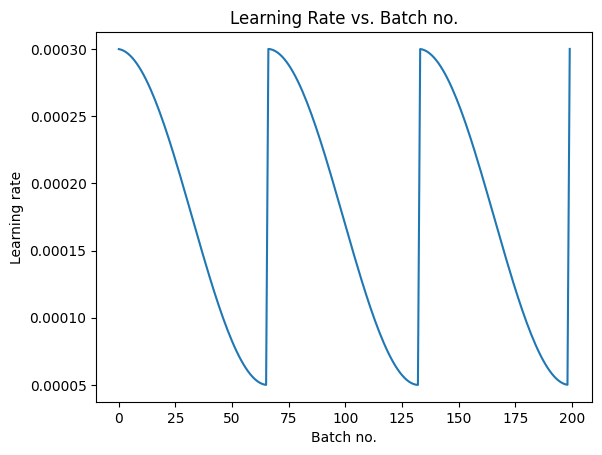

In [58]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning rate')
  plt.title('Learning Rate vs. Batch no.')

plot_lrs(history)

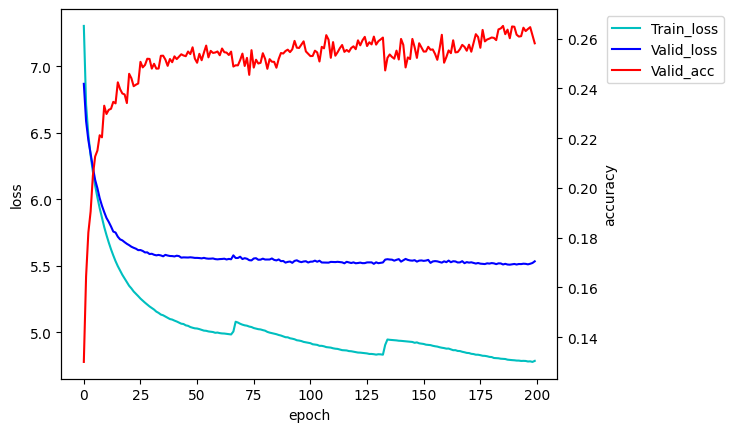

In [59]:
import matplotlib.pyplot as plt

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['valid_loss'] for x in history]
    val_acces = [x['valid_acc'] for x in history]
    
    # Create a figure and axis
    fig, ax1 = plt.subplots()

    # Plot train and validation losses on the left y-axis
    lns1 = ax1.plot(train_losses, '-c', label='Train_loss')
    lns2 = ax1.plot(val_losses, '-b', label='Valid_loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss', color='k')
    ax1.tick_params(axis='y', labelcolor='k')

    # Create a second y-axis for validation accuracy
    ax2 = ax1.twinx()
    lns3 = ax2.plot(val_acces, '-r', label='Valid_acc')
    ax2.set_ylabel('accuracy', color='k')
    ax2.tick_params(axis='y', labelcolor='k')

    # Combine legends for both axes and manually adjust the order
    lns = lns1 + lns2 + lns3
    labels = [l.get_label() for l in lns]
    ax1.legend(lns, labels, loc='upper right', bbox_to_anchor=(1.35, 1))

    # Show the plot
    plt.show()

plot_losses(history)
